In [ ]:
### Import libraries ###
import os
import subprocess
import tempfile
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from eodag import EODataAccessGateway
from pathlib import Path


### Set base path ###
base_path = Path(os.getcwd())
while not (base_path / '.git').exists():
    base_path = base_path.parent
print('Base path: ', base_path)


# import custom functions
sys.path.append(str(base_path / 'src/data/download_S2'))
from utils import process_1Cto2A
from create_merged_tiff import merged_tiff, slc_tiff


## Download from EODAG

Set-up login

In [3]:
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = ""
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = ""
os.environ["EODAG__COP_DATASPACE__AUTH__CREDENTIALS__USERNAME"] = ""
os.environ["EODAG__COP_DATASPACE__AUTH__CREDENTIALS__PASSWORD"] = ""
workspace = base_path / 'data/raw'
workspace = '/scratch/yves/Thesis/Sentinel_data/downloads'
os.environ["EODAG__PEPS__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)
os.environ["EODAG__COP_DATASPACE__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

dag = EODataAccessGateway()
dag.set_preferred_provider("cop_dataspace")

In [4]:
products_to_download = []

Search for products

In [5]:
products, _ = dag.search(
    productType="S2_MSI_L1C",
    start="2016-05-22",
    end="2016-05-23",
    tileIdentifier="36UYA"
)

print(products)
print([p.properties["storageStatus"] for p in products])

[EOProduct(id=S2A_MSIL1C_20160522T083602_N0202_R064_T36UYA_20160522T083605, provider=cop_dataspace), EOProduct(id=S2A_MSIL1C_20160522T083602_N0500_R064_T36UYA_20231025T025840, provider=cop_dataspace)]
['ONLINE', 'ONLINE']


Visualize snapshots

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

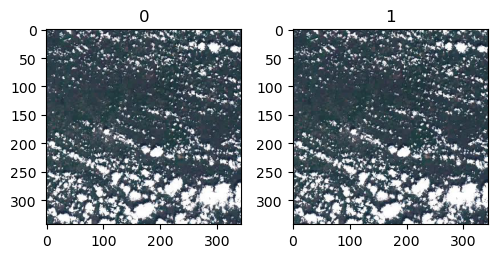

In [6]:
fig = plt.figure(figsize=(10, 8))
for i, product in enumerate(products, start=1):
    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()

    # Plot the quicklook
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(3, 4, i)
    ax.set_title(i - 1)
    plt.imshow(img)
plt.tight_layout()

Extend list to download

In [7]:
products_to_download.append(products[1])
print(products_to_download)

[EOProduct(id=S2A_MSIL1C_20160522T083602_N0500_R064_T36UYA_20231025T025840, provider=cop_dataspace)]


Download products

In [8]:
paths = dag.download_all(products_to_download)

Downloaded products:   0%|          | 0/1 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

## 1C-2A processing

In [ ]:
# Run Sen2Cor
sen2cor_path = os.path.join('/scratch/yves/Thesis', 'Sen2Cor-02.11.00-Linux64', 'bin', 'L2A_Process')
output_dir = os.path.dirname(str(base_path)) + '/Sentinel_data/processed'
process_1Cto2A(paths, output_dir, sen2cor_path)

## SAFE to GeoTIFF conversion

In [ ]:
path = os.path.dirname(str(base_path)) + '/Sentinel_data/processed'
folders = ['S2A_MSIL2A_20160731T084022_N9999_R064_T36UYA_20240419T101242.SAFE', 
           'S2A_MSIL2A_20160830T083602_N9999_R064_T36UYA_20240418T195727.SAFE'] 
data_folders = [path + '/' + folder for folder in folders] 
save_path = str(base_path) + '/data/UKR/raw/full/sentinels'
bands_10m = ['B04', 'B03', 'B02', 'B08']
bands_20m = ['B8A', 'B11', 'B12']


for data_folder in data_folders:
    data_folder = os.path.join(path, data_folder)
    merged_tiff(data_folder, save_path, bands_10m, bands_20m)

## SLC to GeoTIFF conversion

In [ ]:
path = os.path.dirname(str(base_path)) + '/Sentinel_data/processed'
folders = ['S2A_MSIL2A_20160731T084022_N9999_R064_T36UYA_20240419T101242.SAFE', 
           'S2A_MSIL2A_20160830T083602_N9999_R064_T36UYA_20240418T195727.SAFE']
data_folders = [path + '/' + folder for folder in folders] 
save_path = str(base_path) + '/data/UKR/raw/full/clouds'


for data_folder in data_folders:
    data_folder = os.path.join(path, data_folder)
    slc_tiff(data_folder, save_path, resample_to=10)